**решающее дерево**

Евгений Борисов borisov.e@solarl.ru

---

## библиотеки

In [1]:
# import itertools
from time import time

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# from sklearn.metrics import classification_report
# from sklearn.metrics import confusion_matrix
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.metrics import roc_curve
# from sklearn.metrics import auc

---

##  загружаем данные 

In [2]:
# data = [
#     np.loadtxt('../data/200_2b/points_1.txt'),
#     np.loadtxt('../data/200_2b/points_2.txt') 
# ]

In [3]:
# data = [
#     np.loadtxt('../data/399_4/points_b.txt'),
#     np.loadtxt('../data/399_4/points_g.txt'),
#     np.loadtxt('../data/399_4/points_r.txt'),
#     np.loadtxt('../data/399_4/points_y.txt'),
# ]

In [4]:
# "бананы"
# data = [
#     np.loadtxt('../data/6402_2/points_1.txt'),
#     np.loadtxt('../data/6402_2/points_2.txt')
# ]

In [5]:
data = [
    np.loadtxt('../data/1998_2/points_b.txt'),
    np.loadtxt('../data/1998_2/points_r.txt')    
]

---

In [6]:
# собираем вместе
X = np.vstack(data)
n_cls = len(data) # количество классов

In [7]:
# # метки классов
# y = [ [i]*data[i].shape[0] for i in range(n_cls)]
# y = [ item for sublist in y for item in sublist ]
# y = np.asarray(y) 

# X.shape, y.shape

In [8]:
# метки классов
y = [ [i]*data[i].shape[0] for i in range(n_cls)]
y = np.asarray(sum(y,[]))

X.shape, y.shape

((1998, 2), (1998,))

In [9]:
def get_seed(): t = time() ; return int(((t%1)/(t//1))*1e11)

In [10]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.5, random_state=get_seed() )
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((999, 2), (999,), (999, 2), (999,))

In [11]:
%xdel X
%xdel y

---

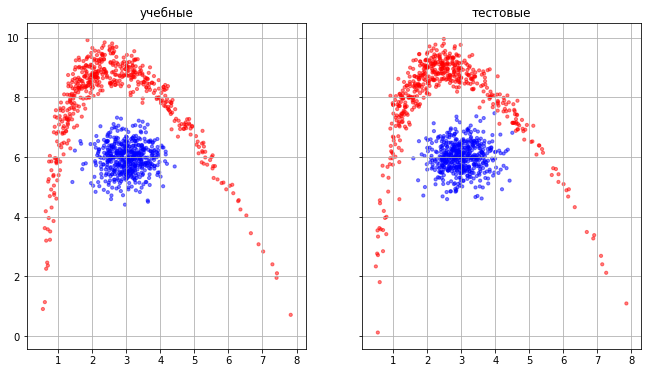

In [12]:
f, axarr = plt.subplots(1,2, sharey=True, sharex=True, figsize=(11,6),)
    
axarr[0].set_title('учебные')
axarr[0].scatter( x=X_train[:,0], 
                  y=X_train[:,1], 
                  c=[['b','r','g','y'][j] for j in y_train ],  
                  s=10,
                  alpha=0.5 )
axarr[0].grid()

axarr[1].set_title('тестовые')
axarr[1].scatter( x=X_test[:,0], 
                  y=X_test[:,1], 
                  c=[ ['b','r','g','y'][j] for j in y_test],
                  s=10,
                  alpha=0.5 )
axarr[1].grid()

plt.show()

---

Алгоритм обучения выглядит следующим образом.

1. если X содержит точки только одного класса то переход на п.6

2. выбрать признак номер $i$ и найти для него пороговое значение $b$, $(min(X_i) < b < max(X_i) )$ с максимальной информативностью разделения

3. сохранить найденную пару $(i,b)$

4. разделить $X$ на две части по признаку $i$ и его порогу $b$

5. выполнить рекурсивно с п.1 для каждого полученного на пред.шаге подмножества

6. конец работы

---

In [71]:
def h(q):
    q = min(0.999, max(1e-9,q))
    return -q*np.log2(q) - (1.0-q)*np.log2(1.0-q)

def igain(s,p_y,p,n):
    # разница в информативности, 
    # до и после примения предиката
    
    # s - количество примеров
    # p_y - количество положительных
    # p - количество положительных примеров, выделенных предикатом   
    # n - количество отрицательных примеров, выделенных предикатом
    
    return h(p_y/s) - (p+n)/s * h(p/(p+n)) + (s-p-n)/s * h( (p_y-p)/(s-p-n))

def info(X,y,b):
    s = len(y) #  количество примеров
    p_y = y.sum() # количество положительных
    
    f = X>b #  отмечаем примеры выделенные предикатом 
    p = y[f].sum() # количество положительных примеров, выделенных предикатом   
    n = -(y[~f]-1).sum() # количество отрицательных примеров, выделенных предикатом
    
    return igain(s,p_y,p,n) # разница в информативности

In [98]:
def search_split(X,y,nb=30):
    # nb = 30 # количество порогов (частей при разбиении отрезка) 

    # список порогов для каждого признака
    b = np.vstack([ np.linspace( X[:,i].min(), X[:,i].max(), nb )[1:-1] for i in range(X.shape[1]) ])

    # изменение информативности для разных признаков и значений порогов 
    inf = np.array([ 
        [ info(X[:,i],y,b[i,j]) for i in range(X.shape[1])  ] 
        for j in range(b.shape[1]) 
    ])

    # параметры с максимальным значением информативности
    j,i = np.unravel_index(inf.argmax(),inf.shape)

    return i,b[i,j]

In [105]:
X = X_train
y = y_train

def build_dtree(X,y):
    i,b = search_split(X,y)

    f = X[:,i]>b
    
    t1=t0=[]
    # если разбиение содержит точки разных классов
    if (y[f].sum()>0) and (y[f].sum() < len(y[f])) : 
        t1 = build_dtree(X[f,:], y[f]) # то повторяем рекурсивно

    if (y[~f].sum()>0) and (y[~f].sum() < len(y[~f])) : 
        t0 = build_dtree(X[~f,:], y[~f])

    return [i,b, t1, t0 ]    



In [109]:
dtree = build_dtree(X,y)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in long_scalars
  


In [111]:
# solve_dtree(dtree)

p = dtree[0]
if(len(p)<1): return 
i = p[0]
b = p[1]



In [ ]:
# %!octave 

# iGain

# % - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
# % информативность
# function retval=information(P,pp),
#    % исключаем из обработки признаки не выделяющие ни одного объекта
#    spp=sum(pp) ; zi=find(spp==0) ; pp(:,zi)=1 ;
#    I=information_entrop(P,pp) ;
#    % обнуляем информативность признаков не выделяющих ни одного объекта
#    I(:,zi)=0 ;
#    retval=I ;
# endfunction


# % - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
# % энтропийная информативность для одного класса
# %
# % P - число объектов в классах (1 x k)
# % pp - число выделенных объектов в классах для каждого признака (k x n)
# %
# function retval=information_entrop(P,pp),
#    P=P' ;
#    N=sum(P)-P ;
#    % исходная энтропия
#    p1=h(P,N) ;
#    % энтропия после выделения объектов бинарными признаками
#    p2=h1(P,pp) ;
#    retval=(p1-p2) ;
# endfunction


# % энтропия на выборках из P-позитивных (условно) и N-негативных элементов
# function retval=h(P,N),
#    % всего элементов
#    S=P+N ;
#    % нормированные позитивные наборы
#    q0=P./S ;
#    % нормированные негативные (дополняющие P) наборы
#    q1=N./S ;
   
#    i=find(q0) ;
#    q0(i)=-q0(i).*log2(q0(i)) ;
   
#    i=find(q1) ;
#    q1(i)=-q1(i).*log2(q1(i)) ;
   
#    retval=(q0+q1) ; 
# endfunction


# % энтропия на выборках из P-позитивных (условно) и N-негативных элементов
# % после получения дополнительной информации
# function retval=h1(P,pp),
#    % всего элементов
#    sP=sum(P) ;
#    % выделенные элементы для каждого признака
#    spp=sum(pp) ;
   
#    N=sP-P ; 
#    % количество элементов, выделенных признаком, не принадлежащих данному классу, для каждого класса
#    nn=spp-pp ;

#    p1=spp./sP .* h(pp,nn) ;
#    p2=(sP-spp)./sP .* h(P-pp,N-nn) ;

#    retval=(p1+p2) ;

# endfunction





